In [1]:
import torch
import matplotlib.pyplot as plt
from torch_sampling import choice

# Checking non-contiguous tensors

In [2]:
x = torch.arange(10)
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [6]:
k=3
print("Sampling with replacement:")
for _ in range(5):
    print(choice(y, True, k))
print("Sampling without replacement:")
for _ in range(5):
    print(choice(y, False, k))

Sampling with replacement:
tensor([3, 3, 6])
tensor([0, 3, 3])
tensor([3, 9, 6])
tensor([3, 0, 9])
tensor([9, 9, 3])
Sampling without replacement:
tensor([0, 9, 6])
tensor([0, 3, 9])
tensor([9, 3, 6])
tensor([0, 9, 6])
tensor([0, 9, 6])


In [7]:
x = torch.arange(10).cuda()
y = x[::3]
for t in [x, y]:
    print(t.is_contiguous())

True
False


In [9]:
k=3
print("Sampling with replacement:")
for _ in range(5):
    print(choice(y, True, k))
print("Sampling without replacement:")
for _ in range(5):
    print(choice(y, False, k))

Sampling with replacement:
tensor([6, 0, 6], device='cuda:0')
tensor([3, 0, 6], device='cuda:0')
tensor([0, 6, 9], device='cuda:0')
tensor([0, 6, 3], device='cuda:0')
tensor([3, 0, 6], device='cuda:0')
Sampling without replacement:
tensor([0, 3, 9], device='cuda:0')
tensor([9, 3, 6], device='cuda:0')
tensor([9, 3, 6], device='cuda:0')
tensor([0, 9, 6], device='cuda:0')
tensor([0, 3, 6], device='cuda:0')


# Check performance for multi-d tensors

In [10]:
x = torch.arange(10**4).view(-1, 2)
n = x.size(0)
k = 3
idx = torch.arange(n)

In [11]:
%timeit x[torch.randperm(n)[:k]]

93.1 µs ± 76.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit x[choice(idx, True, k)]

12.8 µs ± 29.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [13]:
%timeit x[choice(idx, False, k)]

33.1 µs ± 91 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Checking the performance

In [14]:
x = torch.arange(10**4)

# Case 1: k big

In [15]:
k = 9000

In [16]:
%timeit choice(x, True, k)

157 µs ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit choice(x, False, k)

77.4 µs ± 42.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit x[torch.randperm(x.numel())[:k]]

237 µs ± 123 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Case 2: k small

In [19]:
k = 100

In [20]:
%timeit choice(x, True, k)

6.56 µs ± 19.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
%timeit choice(x, False, k)

26 µs ± 33 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [22]:
%timeit x[torch.randperm(x.numel())[:k]]

173 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Case 3: k medium

In [25]:
k = 4500

In [27]:
%timeit choice(x, True, k)

81.6 µs ± 42.3 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [28]:
%timeit choice(x, False, k)

136 µs ± 43.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [29]:
%timeit x[torch.randperm(x.numel())[:k]]

207 µs ± 50.7 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# CUDA vs CPU

In [30]:
x_cpu = torch.arange(10**7)
x_cuda = x_cpu.cuda()
k = 10**4

In [31]:
%timeit choice(x_cpu, True, k)

261 µs ± 7.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit choice(x_cpu, False, k)

21.1 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
%timeit choice(x_cuda, True, k)

24.1 µs ± 54.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
%timeit choice(x_cuda, False, k)

4.22 ms ± 2.81 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
weights_cpu = torch.ones(10**7).double()
weights_cuda = weights_cpu.cuda()

In [38]:
%timeit choice(x_cpu, weights_cpu, False, k)

379 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
%timeit choice(x_cuda, weights_cuda, False, k)

223 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Checking distributions - Uniform

In [40]:
x = torch.arange(10)

### CPP Extension

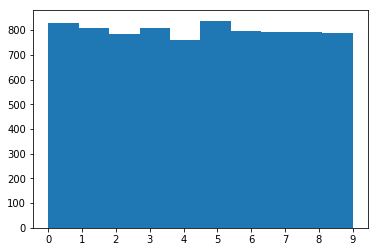

In [41]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, True, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

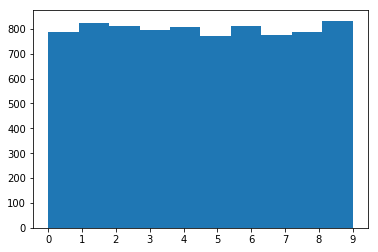

In [42]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, False, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

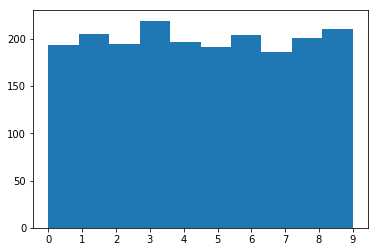

In [43]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, True, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

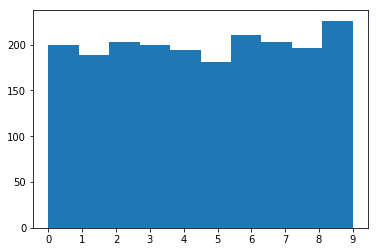

In [44]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, False, k).numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

### CUDA Extension

In [45]:
x = x.cuda()

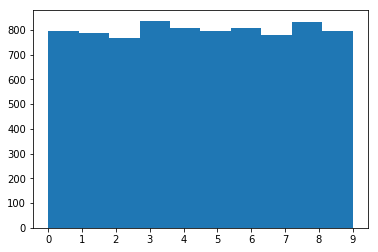

In [47]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, True, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

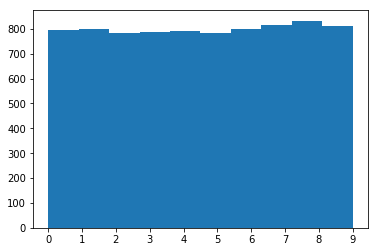

In [48]:
k = 8
samples = []
for _ in range(1000):
    samples.extend(choice(x, False, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

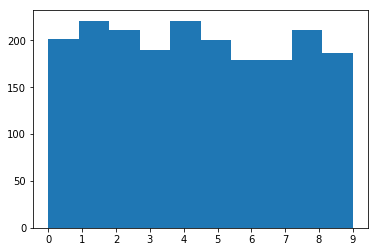

In [49]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, True, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

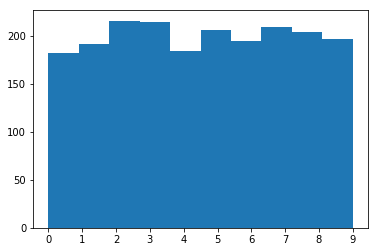

In [51]:
k = 2
samples = []
for _ in range(1000):
    samples.extend(choice(x, False, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

# Checking distributions - Weighted

In [52]:
x = torch.arange(10)
weights = torch.Tensor([1, 1, 5, 5, 5, 1, 7, 2, 2, 2]).float()

### CPP Extension

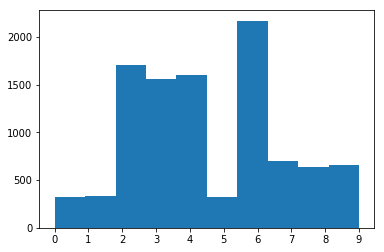

In [53]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, weights, True, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

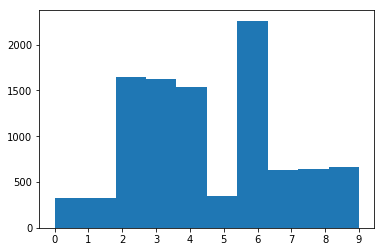

In [54]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, weights, False, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

### CUDA Extension

In [56]:
x = x.cuda()
weights = weights.cuda()

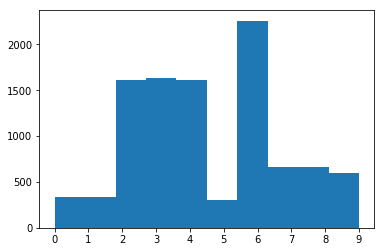

In [57]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, weights, True, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()

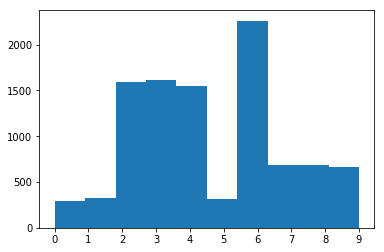

In [58]:
k = 1
samples = []
for _ in range(10000):
    samples.extend(choice(x, weights, False, k).cpu().numpy())
plt.hist(samples)
plt.xticks(range(x.numel()))
plt.show()